In [1]:
import numpy as np
import scipy.optimize as opt
import time
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import deque
from scipy.optimize import differential_evolution
import tensorflow as tf
from tensorflow import keras
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [2]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [3]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "mutation_strategies": ['best1bin', 'rand1bin', 'rand2bin', 'currenttobest1bin', 'best1exp', 'rand1exp'],
    "crossover_strategies": ['bin', 'exp'],
    "cma_step_size": 0.3,
    "egt_max_size": 50,
    "dqn_learning_rate": 0.001,
    "max_generations": 100,
    "num_runs": 30,
    "batch_size": 32}

In [6]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "mutation_strategies": ['best1bin', 'rand1bin', 'rand2bin', 'currenttobest1bin', 'best1exp', 'rand1exp'],
    "crossover_strategies": ['bin', 'exp'],
    "cma_step_size": 0.3,
    "egt_max_size": 50,
    "dqn_learning_rate": 0.001,
    "max_generations": 100,
    "num_runs": 30,
    "batch_size": 32}

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.state_size,)),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def select_action(self, state):
        state = np.array(state).reshape(1, -1)
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def train(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states = np.array([x[0] for x in batch])
        actions = np.array([x[1] for x in batch])
        rewards = np.array([x[2] for x in batch])
        next_states = np.array([x[3] for x in batch])

        targets = rewards + self.gamma * np.max(self.model.predict(next_states, verbose=0), axis=1)
        target_f = self.model.predict(states, verbose=0)
        target_f[np.arange(batch_size), actions] = targets

        self.model.fit(states, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Evolutionary Game Theory Memory
class EGTMemory:
    def __init__(self):
        self.solutions = []
        self.fitness = []
    
    def add_solution(self, solution, fitness):
        self.solutions.append(solution)
        self.fitness.append(fitness)
    
    def extract_patterns(self):
        if len(self.solutions) > 0:
            return self.solutions[np.argmin(self.fitness)]
        return None

class AdaptiveEA:
    def __init__(self, objective_function, bounds, generations, num_runs):
        self.bounds = bounds
        self.objective_function = objective_function
        self.generations = generations
        self.num_runs = num_runs
        self.agent = DQNAgent(state_size=1, action_size=len(CONFIG["mutation_strategies"]))
        self.egt_memory = EGTMemory() 

    def evolve(self):
        all_runs_fitness_history = []
        all_runs_diversity_history = []
        best_solution, best_fitness = None, float('inf')
        start_time = time.time()

        for run in range(self.num_runs):
            print(f"Run {run + 1}/{self.num_runs}")
            solution, fitness, fitness_history, diversity_history = self._evolve_single_run()
            all_runs_fitness_history.append(fitness_history)
            all_runs_diversity_history.append(diversity_history)

            if fitness < best_fitness:
                best_solution, best_fitness = solution, fitness

        execution_time = time.time() - start_time

        return (
            best_solution,
            best_fitness,
            np.mean(all_runs_fitness_history, axis=0),
            np.mean(all_runs_diversity_history, axis=0),
            execution_time)

    def _evolve_single_run(self):
        best_solution, best_fitness = None, float('inf')
        fitness_history = []
        diversity_history = []
        strategies = CONFIG["mutation_strategies"]

        F_values = np.random.uniform(0.4, 0.9, size=len(strategies))
        CR_values = np.random.uniform(0.1, 0.9, size=len(strategies))
        stagnation_counter = 0
        population = np.random.uniform(
            [b[0] for b in self.bounds], [b[1] for b in self.bounds], size=(20, len(self.bounds)))

        start_time = time.time()
        
        for generation in range(self.generations):
            strategy_idx = self.agent.select_action([generation])
            mutation_strategy = strategies[strategy_idx]

            F = np.clip(F_values[strategy_idx] + np.random.normal(0, 0.1), 0.1, 1.0)
            CR = np.clip(CR_values[strategy_idx] + np.random.normal(0, 0.1), 0.1, 1.0)

            result = differential_evolution(
                self.objective_function,
                bounds=self.bounds,
                strategy=mutation_strategy,
                recombination=CR,
                popsize=20,
                tol=0.01,
                mutation=F,
                maxiter=1,
                disp=False,
                updating='deferred')

            if result.fun < best_fitness:
                best_fitness = result.fun
                best_solution = result.x
                stagnation_counter = 0
            else:
                stagnation_counter += 1

            if stagnation_counter >= 10:
                F_values = np.clip(F_values + np.random.normal(0, 0.05), 0.1, 1.0)
                stagnation_counter = 0

            self.egt_memory.add_solution(result.x, result.fun)
            fitness_history.append(result.fun)

            population = np.vstack([population, result.x])
            diversity = np.std(population, axis=0).mean()
            diversity_history.append(diversity)

            if np.random.rand() < 0.1:
                F_values[strategy_idx] = np.clip(F_values[strategy_idx] + np.random.normal(0, 0.02), 0.1, 1.0)
                CR_values[strategy_idx] = np.clip(CR_values[strategy_idx] + np.random.normal(0, 0.02), 0.1, 1.0)

            if generation % 10 == 0:
                pattern = self.egt_memory.extract_patterns()
                if pattern is not None:
                    result.x = pattern

            reward = -result.fun
            next_state = [generation + 1]
            self.agent.memory.append(([generation], strategy_idx, reward, next_state))
            self.agent.train()
            
        return best_solution, best_fitness, fitness_history, diversity_history

## **Sphere function**

Run 1/30
Run 2/30
Run 3/30
Run 4/30
Run 5/30
Run 6/30
Run 7/30
Run 8/30
Run 9/30
Run 10/30
Run 11/30
Run 12/30
Run 13/30
Run 14/30
Run 15/30
Run 16/30
Run 17/30
Run 18/30
Run 19/30
Run 20/30
Run 21/30
Run 22/30
Run 23/30
Run 24/30
Run 25/30
Run 26/30
Run 27/30
Run 28/30
Run 29/30
Run 30/30
Run 1/30
Run 2/30
Run 3/30
Run 4/30
Run 5/30
Run 6/30
Run 7/30
Run 8/30
Run 9/30
Run 10/30
Run 11/30
Run 12/30
Run 13/30
Run 14/30
Run 15/30
Run 16/30
Run 17/30
Run 18/30
Run 19/30
Run 20/30
Run 21/30
Run 22/30
Run 23/30
Run 24/30
Run 25/30
Run 26/30
Run 27/30
Run 28/30
Run 29/30
Run 30/30
Run 1/30
Run 2/30
Run 3/30
Run 4/30
Run 5/30
Run 6/30
Run 7/30
Run 8/30
Run 9/30
Run 10/30
Run 11/30
Run 12/30
Run 13/30
Run 14/30
Run 15/30
Run 16/30
Run 17/30
Run 18/30
Run 19/30
Run 20/30
Run 21/30
Run 22/30
Run 23/30
Run 24/30
Run 25/30
Run 26/30
Run 27/30
Run 28/30
Run 29/30
Run 30/30
Run 1/30
Run 2/30
Run 3/30
Run 4/30
Run 5/30
Run 6/30
Run 7/30
Run 8/30
Run 9/30
Run 10/30
Run 11/30
Run 12/30
Run 13/30
Run 14

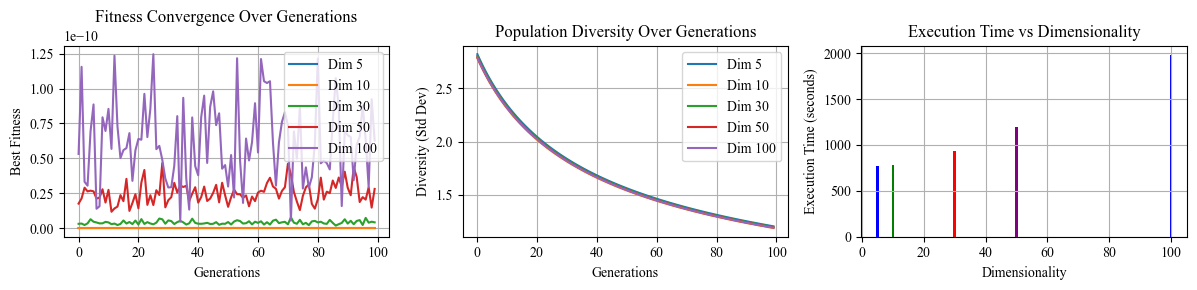

Dimension 5: Best Fitness = 0.00000, Execution Time = 775.346 seconds
Dimension 10: Best Fitness = 0.00000, Execution Time = 778.212 seconds
Dimension 30: Best Fitness = 0.00000, Execution Time = 935.903 seconds
Dimension 50: Best Fitness = 0.00000, Execution Time = 1190.848 seconds
Dimension 100: Best Fitness = 0.00000, Execution Time = 1984.889 seconds


In [7]:
def sphere_function(x):
    return np.sum(x ** 2)

dimensions = [5, 10, 30, 50, 100]
results = {}

for dim in dimensions:
    bounds = [(-5.12, 5.12)] * dim  # Typical search space for Sphere function
    adaptive_ea = AdaptiveEA(sphere_function, bounds, CONFIG["max_generations"], CONFIG["num_runs"])
    best_solution, best_fitness, best_fitness_over_time, diversity_over_time, exec_time = adaptive_ea.evolve()

    results[dim] = {
        "best_fitness": best_fitness,
        "best_fitness_over_time": best_fitness_over_time,
        "diversity_over_time": diversity_over_time,
        "execution_time": exec_time}


fig, axes = plt.subplots(1, 3, figsize=(12, 3))  

# Fitness Convergence
for dim in dimensions:
    axes[0].plot(results[dim]["best_fitness_over_time"], label=f"Dim {dim}")
axes[0].set_xlabel("Generations")
axes[0].set_ylabel("Best Fitness")
axes[0].set_title("Fitness Convergence Over Generations")
axes[0].legend()
axes[0].grid()

# Diversity Evolution
for dim in dimensions:
    axes[1].plot(results[dim]["diversity_over_time"], label=f"Dim {dim}")
axes[1].set_xlabel("Generations")
axes[1].set_ylabel("Diversity (Std Dev)")
axes[1].set_title("Population Diversity Over Generations")
axes[1].legend()
axes[1].grid()

# Execution Time 
axes[2].bar(dimensions, [results[dim]["execution_time"] for dim in dimensions], color=["blue", "green", "red", "purple"])
axes[2].set_xlabel("Dimensionality")
axes[2].set_ylabel("Execution Time (seconds)")
axes[2].set_title("Execution Time vs Dimensionality")
axes[2].grid()

plt.tight_layout()
plt.show()

for dim in dimensions:
    print(f"Dimension {dim}: Best Fitness = {results[dim]['best_fitness']:.5f}, Execution Time = {results[dim]['execution_time']:.3f} seconds")


## **Sinusoidal**

Run 1/30
Run 2/30
Run 3/30
Run 4/30
Run 5/30
Run 6/30
Run 7/30
Run 8/30
Run 9/30
Run 10/30
Run 11/30
Run 12/30
Run 13/30
Run 14/30
Run 15/30
Run 16/30
Run 17/30
Run 18/30
Run 19/30
Run 20/30
Run 21/30
Run 22/30
Run 23/30
Run 24/30
Run 25/30
Run 26/30
Run 27/30
Run 28/30
Run 29/30
Run 30/30
Run 1/30
Run 2/30
Run 3/30
Run 4/30
Run 5/30
Run 6/30
Run 7/30
Run 8/30
Run 9/30
Run 10/30
Run 11/30
Run 12/30
Run 13/30
Run 14/30
Run 15/30
Run 16/30
Run 17/30
Run 18/30
Run 19/30
Run 20/30
Run 21/30
Run 22/30
Run 23/30
Run 24/30
Run 25/30
Run 26/30
Run 27/30
Run 28/30
Run 29/30
Run 30/30
Run 1/30
Run 2/30
Run 3/30
Run 4/30
Run 5/30
Run 6/30
Run 7/30
Run 8/30
Run 9/30
Run 10/30
Run 11/30
Run 12/30
Run 13/30
Run 14/30
Run 15/30
Run 16/30
Run 17/30
Run 18/30
Run 19/30
Run 20/30
Run 21/30
Run 22/30
Run 23/30
Run 24/30
Run 25/30
Run 26/30
Run 27/30
Run 28/30
Run 29/30
Run 30/30
Run 1/30
Run 2/30
Run 3/30
Run 4/30
Run 5/30
Run 6/30
Run 7/30
Run 8/30
Run 9/30
Run 10/30
Run 11/30
Run 12/30
Run 13/30
Run 14

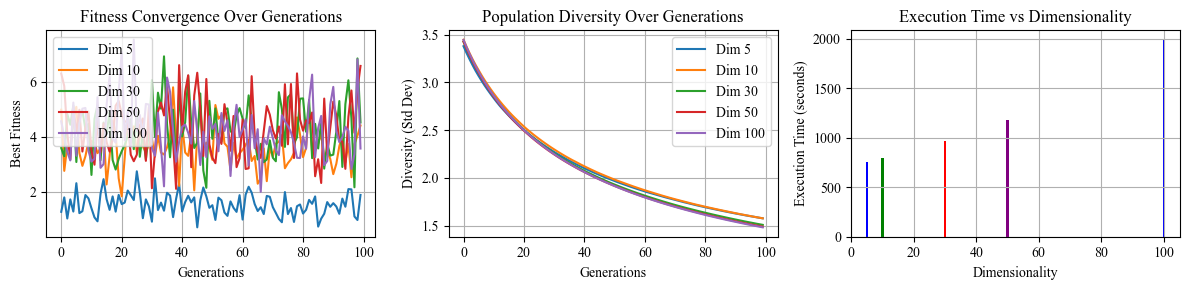

Dimension 5: Best Fitness = -0.98016, Execution Time = 757.103 seconds
Dimension 10: Best Fitness = -0.98016, Execution Time = 792.557 seconds
Dimension 30: Best Fitness = -0.98016, Execution Time = 970.073 seconds
Dimension 50: Best Fitness = -0.98016, Execution Time = 1176.249 seconds
Dimension 100: Best Fitness = -0.98016, Execution Time = 1987.511 seconds


In [8]:
def sinusoidal_function(x):
    return np.sin(5 * np.pi * x[0]) * np.sin(5 * np.pi * x[1]) + np.sum(np.square(x))

bounds = [-2*3.1416, 2*3.1416] # [−2π,2π]
dimensions = [5, 10, 30, 50, 100]
results = {}

for dim in dimensions:
    bounds = [(-2 * np.pi, 2 * np.pi)] * dim  
    adaptive_ea = AdaptiveEA(sinusoidal_function, bounds, CONFIG["max_generations"], CONFIG["num_runs"])
    best_solution, best_fitness, best_fitness_over_time, diversity_over_time, exec_time = adaptive_ea.evolve()

    results[dim] = {
        "best_fitness": best_fitness,
        "best_fitness_over_time": best_fitness_over_time,
        "diversity_over_time": diversity_over_time,
        "execution_time": exec_time}


fig, axes = plt.subplots(1, 3, figsize=(12, 3))  

# Fitness Convergence
for dim in dimensions:
    axes[0].plot(results[dim]["best_fitness_over_time"], label=f"Dim {dim}")
axes[0].set_xlabel("Generations")
axes[0].set_ylabel("Best Fitness")
axes[0].set_title("Fitness Convergence Over Generations")
axes[0].legend()
axes[0].grid()

# Diversity Evolution
for dim in dimensions:
    axes[1].plot(results[dim]["diversity_over_time"], label=f"Dim {dim}")
axes[1].set_xlabel("Generations")
axes[1].set_ylabel("Diversity (Std Dev)")
axes[1].set_title("Population Diversity Over Generations")
axes[1].legend()
axes[1].grid()

# Execution Time 
axes[2].bar(dimensions, [results[dim]["execution_time"] for dim in dimensions], color=["blue", "green", "red", "purple"])
axes[2].set_xlabel("Dimensionality")
axes[2].set_ylabel("Execution Time (seconds)")
axes[2].set_title("Execution Time vs Dimensionality")
axes[2].grid()

plt.tight_layout()
plt.show()

for dim in dimensions:
    print(f"Dimension {dim}: Best Fitness = {results[dim]['best_fitness']:.5f}, Execution Time = {results[dim]['execution_time']:.3f} seconds")
